# Principal component analysis (PCA) for novelty detection
This notebook shows how to use the PCA method for novelty detection for the Mastcam multispectral image dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os

import datasets

np.random.seed(42)

## 1. Compute principal components using typical images

Load the training dataset

In [3]:
train_dir = '/home/jovyan/data/train_typical'

Some images have a black stripe (image artifact) on the side. We want to remove these images from the dataset since they are not a "typical" feature in Mastcam images of the Mars surface.

In [4]:
train_data, train_names = datasets.load_6f_images(train_dir, shuffle=True, remove_striped=True)

('Loaded dataset with shape:', (9124, 64, 64, 6))


In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=100, svd_solver='full')

In [7]:
# Flatten the multispectral image tensors into vectors
train_data = np.reshape(train_data, [train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3]])
train_data.shape

(9124, 24576)

In [8]:
%time pca.fit(train_data)

CPU times: user 16min 27s, sys: 1min 12s, total: 17min 40s
Wall time: 1min 15s


PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

## 2. Compute novelty scores for test data
The novelty score in PCA is the residual between the input image and the image reconstructed from the top k principal components. The residual is defined here as the L2 loss. We compute these scores for all typical and novel test images.

Load the typical test data

In [9]:
test_dir = '/home/jovyan/data/test_typical'

In [10]:
test_data_typical, test_names_typical = datasets.load_6f_images(test_dir, shuffle=True, remove_striped=True)

('Loaded dataset with shape:', (420, 64, 64, 6))


In [11]:
# Flatten the multispectral image tensors into vectors
test_data_typical = np.reshape(test_data_typical, [test_data_typical.shape[0], test_data_typical.shape[1]*test_data_typical.shape[2]*test_data_typical.shape[3]])
test_data_typical.shape

(420, 24576)

Compute scores by projecting images onto the first k principal components then computing the reconstruction using the inverse transform, and compute the L2 loss between the input and reconstructed images

In [12]:
recon_typical = pca.inverse_transform(pca.transform(test_data_typical))

In [13]:
scores_typical = np.linalg.norm(test_data_typical - recon_typical, ord=2, axis=1)

Load the novel test data 

In [15]:
test_dir_novel = '/home/jovyan/data/test_novel'

In [16]:
input_novel = {}
scores_novel = {}
novel_categories = ['all', 'bedrock', 'broken-rock', 'drill-hole', 'drt', 'dump-pile', 'float', 'meteorite', 'veins']
for cat in novel_categories:
    # Load the dataset
    data, names = datasets.load_6f_images(os.path.join(test_dir_novel, cat), shuffle=False, remove_striped=True)
    input_novel[cat] = data
    data = np.reshape(data, [data.shape[0], data.shape[1]*data.shape[2]*data.shape[3]])
    recon = pca.inverse_transform(pca.transform(data))
    scores_novel[cat] = np.linalg.norm(data - recon, ord=2, axis=1)

('Loaded dataset with shape:', (430, 64, 64, 6))
('Loaded dataset with shape:', (11, 64, 64, 6))
('Loaded dataset with shape:', (76, 64, 64, 6))
('Loaded dataset with shape:', (62, 64, 64, 6))
('Loaded dataset with shape:', (111, 64, 64, 6))
('Loaded dataset with shape:', (93, 64, 64, 6))
('Loaded dataset with shape:', (18, 64, 64, 6))
('Loaded dataset with shape:', (34, 64, 64, 6))
('Loaded dataset with shape:', (30, 64, 64, 6))


Plot the distribution of novelty scores for each class

Text(0,0.5,'Density')

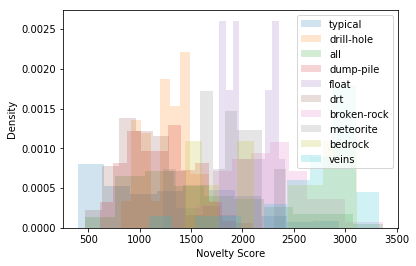

In [17]:
plt.hist(scores_typical, alpha=0.2, label='typical', density=True)
for cat in scores_novel.keys():
    plt.hist(scores_novel[cat], alpha=0.2, label=cat, density=True)
plt.legend()
plt.xlabel('Novelty Score')
plt.ylabel('Density')

## 3. Evaluate PCA performance for novelty detection
We used two metrics for quantitatively evaluating performance: area under the curve (AUC) of the receiver operator characteristic (ROC) curve and precision at N. Precision at N is the fraction of correct classifications in the top N images when sorted by novelty score (i.e., the fraction of novel images in the top N test images sorted by novelty score).

### Compute AUC scores

In [18]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

Text(0.5,0,'True positive rate')

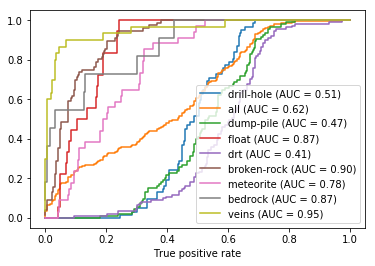

In [19]:
for cat in scores_novel.keys():
    scores = np.concatenate([scores_typical, scores_novel[cat]])
    labels = np.concatenate([np.zeros(scores_typical.shape), np.ones(scores_novel[cat].shape)])
    fpr, tpr, thresholds = roc_curve(y_true=labels, y_score=scores)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (cat, auc_score))
plt.legend()
plt.xlabel("False positive rate")
plt.xlabel("True positive rate")

### Compute Precision at N

Sort the combined test dataset (novel and typical images) by their novelty score

In [20]:
test_data_novel, test_names_novel = datasets.load_6f_images(os.path.join(test_dir_novel, 'all'), shuffle=False, remove_striped=True)

('Loaded dataset with shape:', (430, 64, 64, 6))


In [21]:
combined_scores = np.concatenate([scores_typical, scores_novel[cat]])

In [22]:
combined_labels = np.concatenate([np.zeros(scores_typical.shape), np.ones(scores_novel['all'].shape)])

In [25]:
test_data_typical = np.reshape(test_data_typical, [test_data_typical.shape[0], 64, 64, 6])

In [27]:
combined_inputs = np.concatenate([test_data_typical, test_data_novel])

In [28]:
combined_names = np.concatenate([test_names_typical, test_names_novel])

In [29]:
# Sort the scores, labels, filenames, and inputs by novelty score 
sorted_scores = sorted(zip(combined_scores, combined_labels, combined_names, combined_inputs), key=lambda tup: tup[0], reverse=True)
combined_scores, combined_labels, combined_names, combined_inputs = zip(*sorted_scores)

Compute Precision at N for the top-ranked images

In [30]:
# Choose the top N
N = 10
top_scores = combined_scores[:N]
top_labels = combined_labels[:N]
top_names = combined_names[:N]
top_images = combined_inputs[:N]

Precision at N=10: 0.900000


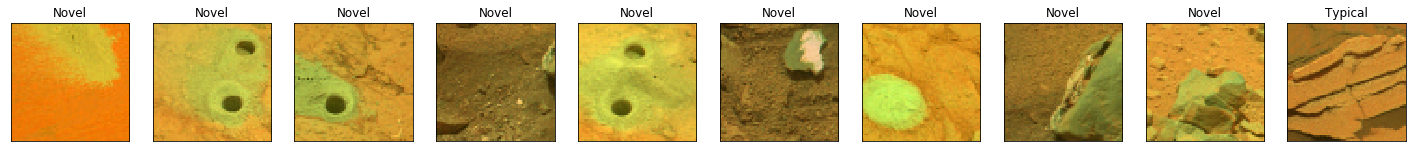

In [31]:
fig, axes = plt.subplots(ncols=N, figsize=(25, 15))
for i, img in enumerate(top_images):
    img = np.take(img, [2,0,1], axis=2)
    axes[i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
    axes[i].grid(False)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    if top_labels[i] == 0:
        axes[i].set_title('Typical')
    elif top_labels[i] == 1:
        axes[i].set_title('Novel')

precision_at_N = len(np.where(np.array(top_labels) == 1)[0])
precision_at_N = precision_at_N / float(N)
print("Precision at N=%d: %f" % (N, precision_at_N))

### Compute False Negatives at N

False Negatives at N is the fraction of novel images that appear in the bottom N images when ranked by novelty score.

In [32]:
# Choose the bottom N
bottom_scores = combined_scores[-N:]
bottom_labels = combined_labels[-N:]
bottom_names = combined_names[-N:]
bottom_images = combined_inputs[-N:]

Precision at N=10: 1.000000


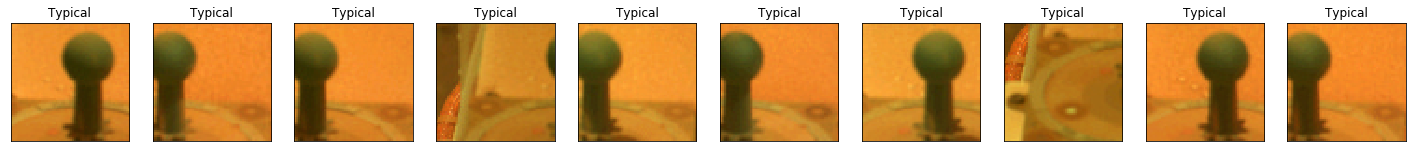

In [33]:
fig, axes = plt.subplots(ncols=N, figsize=(25, 15))
for i, img in enumerate(bottom_images):
    img = np.take(img, [2,0,1], axis=2)
    axes[i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
    axes[i].grid(False)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    if bottom_labels[i] == 0:
        axes[i].set_title('Typical')
    elif bottom_labels[i] == 1:
        axes[i].set_title('Novel')

precision_at_N = len(np.where(np.array(bottom_labels) == 0)[0])
precision_at_N = precision_at_N / float(N)
print("Precision at N=%d: %f" % (N, precision_at_N))